https://github.com/Binbose/LSTM-sine-generator-keras

https://fairyonice.github.io/Understand-Keras's-RNN-behind-the-scenes-with-a-sin-wave-example.html

In [2]:
import sys
print(sys.version)
import tensorflow
print(tensorflow.__version__)
import keras
print(keras.__version__)

3.8.8 (default, Feb 24 2021, 21:46:12) 
[GCC 7.3.0]
2.4.1
2.4.3


In [ ]:
# def noisy_sin(steps_per_cycle = 50,
#               number_of_cycles = 500,
#               random_factor = 0.4):
#     '''
#     random_factor    : amont of noise in sign wave. 0 = no noise
#     number_of_cycles : The number of steps required for one cycle
    
#     Return : 
#     pd.DataFrame() with column sin_t containing the generated sin wave 
#     '''
#     random.seed(0)
#     df = pd.DataFrame(np.arange(steps_per_cycle * number_of_cycles + 1), columns=["t"])
#     df["sin_t"] = df.t.apply(lambda x: math.sin(x * (2 * math.pi / steps_per_cycle)+ random.uniform(-1.0, +1.0) * random_factor))
#     df["sin_t_clean"] = df.t.apply(lambda x: math.sin(x * (2 * math.pi / steps_per_cycle)))
#     print("create period-{} sin wave with {} cycles".format(steps_per_cycle,number_of_cycles))
#     print("In total, the sin wave time series length is {}".format(steps_per_cycle*number_of_cycles+1))
#     return(df)



# steps_per_cycle = 10
# df = noisy_sin(steps_per_cycle=steps_per_cycle,
#               random_factor = 0)

# n_plot = 8
# df[["sin_t"]].head(steps_per_cycle * n_plot).plot(
#       title="Generated first {} cycles".format(n_plot),
#       figsize=(15,3))

In [10]:
trainX.shape, testX.shape

((1200, 1, 1), (1000, 1, 1))

In [23]:
see_train = array([generateTrainData(series, i, look_back) for i in range(lengthTrain)])
see_train, see_train.shape

(array([[ 0.        ,  0.0628178 ],
        [ 0.0628178 ,  0.12538746],
        [ 0.12538746,  0.18746185],
        ...,
        [-0.15515214, -0.0927886 ],
        [-0.0927886 , -0.03005856],
        [-0.03005856,  0.03279022]]),
 (1200, 2))

In [44]:
see_train.reshape((lengthTrain,look_back + 1, 1))[0:3,:,:]

array([[[0.        ],
        [0.0628178 ]],

       [[0.0628178 ],
        [0.12538746]],

       [[0.12538746],
        [0.18746185]]])

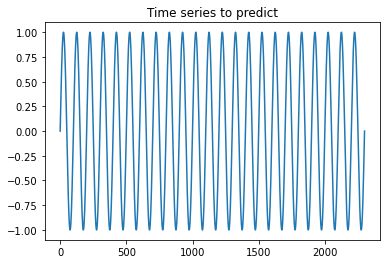

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         [(1, 1, 1)]          0                                            
__________________________________________________________________________________________________
lstm_2 (LSTM)                   (1, 1, 128)          66560       main_input[0][0]                 
__________________________________________________________________________________________________
aux_input (InputLayer)          [(1, 1, 1)]          0                                            
__________________________________________________________________________________________________
time_distributed_4 (TimeDistrib (1, 1, 1)            129         lstm_2[0][0]                     
____________________________________________________________________________________________

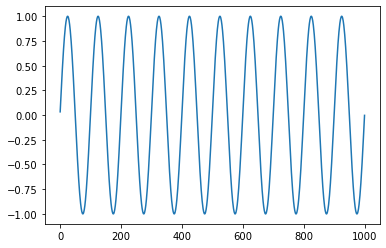

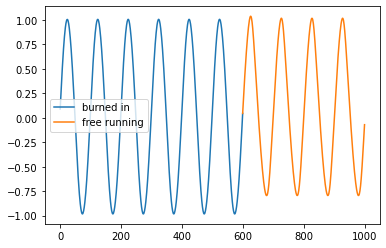

In [48]:
import numpy as np
import matplotlib.pyplot as plt

# Model (especially sine amplitude) depends on random seed
# By twaking the architecture it could be made more robust
np.random.seed(4)

# Generating 23 periods of sine
width = np.pi*2*23
numOfSamples = 2300
lengthTrain = 1200
lengthValidation = 1000
look_back = 1 # Can be set higher, in my experiments it made performance worse though
transientTime = 600 # Time to "burn in" time series

series = np.sin(np.linspace(0,width,numOfSamples))
plt.plot(series)
plt.title("Time series to predict")
plt.show()

def generateTrainData(series, i, look_back):
    return series[i:look_back+i+1]

trainX = np.stack([generateTrainData(series, i, look_back) for i in range(lengthTrain)])
testX = np.stack([generateTrainData(series, lengthTrain + i, look_back) for i in range(lengthValidation)])

trainX = trainX.reshape((lengthTrain,look_back + 1, 1))
testX = testX.reshape((lengthValidation, look_back + 1, 1))

# for look_back=1, the code below will make trainX be shape (lengthTrain,look_back,1)=(lengthTrain,1,1), i.e. without the +1
# I think X is the input and Y is the output, which is the prediction of the function in the next time step
trainY = trainX[:,1:,:]  # Y is one step after X
trainX = trainX[:,:-1,:]

testY = testX[:,1:,:]
testX = testX[:,:-1,:]

############### Build Model ###############

import keras
from keras.models import Sequential, Model
from keras import layers
from keras import regularizers

inputs = layers.Input(batch_shape=(1,look_back,1), name="main_input")  
# look_back is changing the size of the batch, why? What is the look_back for?
inputsAux = layers.Input(batch_shape=(1,look_back,1), name="aux_input")

# this layer makes the actual prediction, i.e. decides if and how much it goes up or down
x = layers.recurrent.LSTM(128,return_sequences=True, stateful=True)(inputs)
x = layers.wrappers.TimeDistributed(layers.Dense(1, activation="linear",
                                                 kernel_regularizer=regularizers.l2(0.005),
                                                 activity_regularizer=regularizers.l1(0.005)))(x)

# auxillary input, the current input will be feed directly to the output
# this way the prediction from the step before will be used as a "base", and the Network just have to
# learn if it goes a little up or down
auxX = layers.wrappers.TimeDistributed(layers.Dense(1,
                                                    kernel_initializer=keras.initializers.Constant(value=1),
                                                    bias_initializer='zeros',
                                                    input_shape=(1,1), activation="linear", trainable=False
                                                    ))(inputsAux)

outputs = layers.add([x, auxX], name="main_output")
model = Model(inputs=[inputs, inputsAux], outputs=outputs)  # create a model by specifying which of the layers specified are inputs and outputs
model.compile(optimizer='rmsprop',
              loss='mean_squared_error',
              metrics=['mean_squared_error'])
model.summary()
model.fit({"main_input": trainX, "aux_input": trainX[:,look_back-1,:].reshape(lengthTrain,1,1)},{"main_output": trainY}, epochs=4, batch_size=1, shuffle=False)



############### make predictions ###############

burnedInPredictions = np.zeros(transientTime)
testPredictions = np.zeros(len(testX))
# burn series in, here use first transitionTime number of samples from test data
for i in range(transientTime):
    prediction = model.predict([np.array(testX[i, :, 0].reshape(1, look_back, 1)), np.array(testX[i, look_back - 1, 0].reshape(1, 1, 1))])
    testPredictions[i] = prediction[0,0,0]
# make prediction of the next step using the true value of the previous step
    
burnedInPredictions[:] = testPredictions[:transientTime]

# prediction, now dont use any previous data whatsoever anymore, network just has to run on its own output
# first it uses the last prediction from the burnIn and then uses its own
for i in range(transientTime, len(testX)):
    prediction = model.predict([prediction, prediction])
    testPredictions[i] = prediction[0,0,0]
# this one has higher error because small prediction errors accumulate

# for plotting reasons: make the array have nans so that it won't obstruct the plot of burnedInPredictions
testPredictions[:np.size(burnedInPredictions)-1] = np.nan



############### plot results ###############
import matplotlib.pyplot as plt
plt.plot(testX[:, 0, 0])
plt.show()
plt.plot(burnedInPredictions, label = "burned in")
plt.plot(testPredictions, label = "free running")
plt.legend()
plt.show()

No idea why it gets higher amplitude above and lower below at the free running period

# XOR feedforward example

In [46]:
# taken from https://gist.github.com/stewartpark/187895beb89f0a1b3a54

from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.optimizers import SGD
import numpy as np

X = np.array([[0,0],[0,1],[1,0],[1,1]])
y = np.array([[0],[1],[1],[0]])

model = Sequential()
model.add(Dense(2, input_dim=2))
# model.add(Dense(8, input_dim=2))
model.add(Activation('tanh'))
model.add(Dense(1))
model.add(Activation('sigmoid'))

sgd = SGD(lr=0.1)
model.compile(loss='mean_squared_error', optimizer=sgd)
# model.compile(loss='binary_crossentropy', optimizer=sgd)
model.summary()

model.fit(X, y, batch_size=1, epochs=2000)
print(model.predict(X))
# output with 8 hidden units
# """
# [[ 0.0033028 ]
#  [ 0.99581173]
#  [ 0.99530098]
#  [ 0.00564186]]
# """

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 2)                 6         
_________________________________________________________________
activation_2 (Activation)    (None, 2)                 0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 3         
_________________________________________________________________
activation_3 (Activation)    (None, 1)                 0         
Total params: 9
Trainable params: 9
Non-trainable params: 0
_________________________________________________________________
Epoch 1/2000
4/4 [==============================] - 1s 2ms/step - loss: 0.2465
Epoch 2/2000
4/4 [==============================] - 0s 1ms/step - loss: 0.2387
Epoch 3/2000
4/4 [==============================] - 0s 1ms/step - loss: 0.2464
Epoch 4/2000
4/4 [===

4/4 [==============================] - 0s 1ms/step - loss: 0.1488
Epoch 194/2000
4/4 [==============================] - 0s 1ms/step - loss: 0.1568
Epoch 195/2000
4/4 [==============================] - 0s 1ms/step - loss: 0.2397
Epoch 196/2000
4/4 [==============================] - 0s 2ms/step - loss: 0.1557
Epoch 197/2000
4/4 [==============================] - 0s 1ms/step - loss: 0.1968
Epoch 198/2000
4/4 [==============================] - 0s 1ms/step - loss: 0.2272
Epoch 199/2000
4/4 [==============================] - 0s 1ms/step - loss: 0.1524
Epoch 200/2000
4/4 [==============================] - 0s 1ms/step - loss: 0.1348
Epoch 201/2000
4/4 [==============================] - 0s 1ms/step - loss: 0.1512
Epoch 202/2000
4/4 [==============================] - 0s 1ms/step - loss: 0.2286
Epoch 203/2000
4/4 [==============================] - 0s 1ms/step - loss: 0.1426
Epoch 204/2000
4/4 [==============================] - 0s 1ms/step - loss: 0.1933
Epoch 205/2000
4/4 [=======================

4/4 [==============================] - 0s 1ms/step - loss: 0.0220
Epoch 396/2000
4/4 [==============================] - 0s 1ms/step - loss: 0.0281
Epoch 397/2000
4/4 [==============================] - 0s 1ms/step - loss: 0.0221
Epoch 398/2000
4/4 [==============================] - 0s 1ms/step - loss: 0.0267
Epoch 399/2000
4/4 [==============================] - 0s 1ms/step - loss: 0.0224
Epoch 400/2000
4/4 [==============================] - 0s 1ms/step - loss: 0.0219
Epoch 401/2000
4/4 [==============================] - 0s 1ms/step - loss: 0.0270
Epoch 402/2000
4/4 [==============================] - 0s 1ms/step - loss: 0.0232
Epoch 403/2000
4/4 [==============================] - 0s 1ms/step - loss: 0.0245
Epoch 404/2000
4/4 [==============================] - 0s 1ms/step - loss: 0.0229
Epoch 405/2000
4/4 [==============================] - 0s 2ms/step - loss: 0.0215
Epoch 406/2000
4/4 [==============================] - 0s 1ms/step - loss: 0.0203
Epoch 407/2000
4/4 [=======================

4/4 [==============================] - 0s 2ms/step - loss: 0.0087
Epoch 598/2000
4/4 [==============================] - 0s 2ms/step - loss: 0.0083
Epoch 599/2000
4/4 [==============================] - 0s 2ms/step - loss: 0.0093
Epoch 600/2000
4/4 [==============================] - 0s 2ms/step - loss: 0.0104
Epoch 601/2000
4/4 [==============================] - 0s 2ms/step - loss: 0.0091
Epoch 602/2000
4/4 [==============================] - 0s 1ms/step - loss: 0.0092
Epoch 603/2000
4/4 [==============================] - 0s 2ms/step - loss: 0.0104
Epoch 604/2000
4/4 [==============================] - 0s 3ms/step - loss: 0.0097
Epoch 605/2000
4/4 [==============================] - 0s 2ms/step - loss: 0.0098
Epoch 606/2000
4/4 [==============================] - 0s 2ms/step - loss: 0.0103
Epoch 607/2000
4/4 [==============================] - 0s 2ms/step - loss: 0.0089
Epoch 608/2000
4/4 [==============================] - 0s 2ms/step - loss: 0.0077
Epoch 609/2000
4/4 [=======================

4/4 [==============================] - 0s 1ms/step - loss: 0.0057
Epoch 800/2000
4/4 [==============================] - 0s 2ms/step - loss: 0.0056
Epoch 801/2000
4/4 [==============================] - 0s 2ms/step - loss: 0.0051
Epoch 802/2000
4/4 [==============================] - 0s 2ms/step - loss: 0.0049
Epoch 803/2000
4/4 [==============================] - 0s 1ms/step - loss: 0.0051
Epoch 804/2000
4/4 [==============================] - 0s 2ms/step - loss: 0.0056
Epoch 805/2000
4/4 [==============================] - 0s 1ms/step - loss: 0.0045
Epoch 806/2000
4/4 [==============================] - 0s 2ms/step - loss: 0.0053
Epoch 807/2000
4/4 [==============================] - 0s 1ms/step - loss: 0.0049
Epoch 808/2000
4/4 [==============================] - 0s 2ms/step - loss: 0.0045
Epoch 809/2000
4/4 [==============================] - 0s 1ms/step - loss: 0.0050
Epoch 810/2000
4/4 [==============================] - 0s 2ms/step - loss: 0.0052
Epoch 811/2000
4/4 [=======================

4/4 [==============================] - 0s 2ms/step - loss: 0.0035
Epoch 1002/2000
4/4 [==============================] - 0s 2ms/step - loss: 0.0035
Epoch 1003/2000
4/4 [==============================] - 0s 2ms/step - loss: 0.0031
Epoch 1004/2000
4/4 [==============================] - 0s 1ms/step - loss: 0.0031
Epoch 1005/2000
4/4 [==============================] - 0s 2ms/step - loss: 0.0033
Epoch 1006/2000
4/4 [==============================] - 0s 1ms/step - loss: 0.0033
Epoch 1007/2000
4/4 [==============================] - 0s 2ms/step - loss: 0.0038
Epoch 1008/2000
4/4 [==============================] - 0s 1ms/step - loss: 0.0034
Epoch 1009/2000
4/4 [==============================] - 0s 2ms/step - loss: 0.0035
Epoch 1010/2000
4/4 [==============================] - 0s 1ms/step - loss: 0.0039
Epoch 1011/2000
4/4 [==============================] - 0s 2ms/step - loss: 0.0038
Epoch 1012/2000
4/4 [==============================] - 0s 1ms/step - loss: 0.0039
Epoch 1013/2000
4/4 [===========

4/4 [==============================] - 0s 2ms/step - loss: 0.0035
Epoch 1102/2000
4/4 [==============================] - 0s 2ms/step - loss: 0.0037
Epoch 1103/2000
4/4 [==============================] - 0s 2ms/step - loss: 0.0035
Epoch 1104/2000
4/4 [==============================] - 0s 1ms/step - loss: 0.0031
Epoch 1105/2000
4/4 [==============================] - 0s 2ms/step - loss: 0.0034
Epoch 1106/2000
4/4 [==============================] - 0s 2ms/step - loss: 0.0030
Epoch 1107/2000
4/4 [==============================] - 0s 2ms/step - loss: 0.0032
Epoch 1108/2000
4/4 [==============================] - 0s 2ms/step - loss: 0.0027
Epoch 1109/2000
4/4 [==============================] - 0s 2ms/step - loss: 0.0034
Epoch 1110/2000
4/4 [==============================] - 0s 2ms/step - loss: 0.0032
Epoch 1111/2000
4/4 [==============================] - 0s 2ms/step - loss: 0.0034
Epoch 1112/2000
4/4 [==============================] - 0s 1ms/step - loss: 0.0028
Epoch 1113/2000
4/4 [===========

4/4 [==============================] - 0s 1ms/step - loss: 0.0025
Epoch 1202/2000
4/4 [==============================] - 0s 1ms/step - loss: 0.0028
Epoch 1203/2000
4/4 [==============================] - 0s 4ms/step - loss: 0.0030
Epoch 1204/2000
4/4 [==============================] - 0s 2ms/step - loss: 0.0029
Epoch 1205/2000
4/4 [==============================] - 0s 2ms/step - loss: 0.0032
Epoch 1206/2000
4/4 [==============================] - 0s 1ms/step - loss: 0.0032
Epoch 1207/2000
4/4 [==============================] - 0s 1ms/step - loss: 0.0029
Epoch 1208/2000
4/4 [==============================] - 0s 2ms/step - loss: 0.0031
Epoch 1209/2000
4/4 [==============================] - 0s 2ms/step - loss: 0.0025
Epoch 1210/2000
4/4 [==============================] - 0s 2ms/step - loss: 0.0031
Epoch 1211/2000
4/4 [==============================] - 0s 2ms/step - loss: 0.0025
Epoch 1212/2000
4/4 [==============================] - 0s 2ms/step - loss: 0.0028
Epoch 1213/2000
4/4 [===========

4/4 [==============================] - 0s 1ms/step - loss: 0.0026
Epoch 1302/2000
4/4 [==============================] - 0s 2ms/step - loss: 0.0023
Epoch 1303/2000
4/4 [==============================] - 0s 2ms/step - loss: 0.0021
Epoch 1304/2000
4/4 [==============================] - 0s 2ms/step - loss: 0.0023
Epoch 1305/2000
4/4 [==============================] - 0s 2ms/step - loss: 0.0028
Epoch 1306/2000
4/4 [==============================] - 0s 1ms/step - loss: 0.0029
Epoch 1307/2000
4/4 [==============================] - 0s 2ms/step - loss: 0.0028
Epoch 1308/2000
4/4 [==============================] - 0s 2ms/step - loss: 0.0021
Epoch 1309/2000
4/4 [==============================] - 0s 2ms/step - loss: 0.0022
Epoch 1310/2000
4/4 [==============================] - 0s 1ms/step - loss: 0.0028
Epoch 1311/2000
4/4 [==============================] - 0s 2ms/step - loss: 0.0028
Epoch 1312/2000
4/4 [==============================] - 0s 2ms/step - loss: 0.0022
Epoch 1313/2000
4/4 [===========

4/4 [==============================] - 0s 2ms/step - loss: 0.0026
Epoch 1402/2000
4/4 [==============================] - 0s 2ms/step - loss: 0.0020
Epoch 1403/2000
4/4 [==============================] - 0s 2ms/step - loss: 0.0023
Epoch 1404/2000
4/4 [==============================] - 0s 2ms/step - loss: 0.0021
Epoch 1405/2000
4/4 [==============================] - 0s 2ms/step - loss: 0.0022
Epoch 1406/2000
4/4 [==============================] - 0s 1ms/step - loss: 0.0021
Epoch 1407/2000
4/4 [==============================] - 0s 2ms/step - loss: 0.0023
Epoch 1408/2000
4/4 [==============================] - 0s 2ms/step - loss: 0.0020
Epoch 1409/2000
4/4 [==============================] - 0s 2ms/step - loss: 0.0020
Epoch 1410/2000
4/4 [==============================] - 0s 2ms/step - loss: 0.0019
Epoch 1411/2000
4/4 [==============================] - 0s 2ms/step - loss: 0.0020
Epoch 1412/2000
4/4 [==============================] - 0s 2ms/step - loss: 0.0020
Epoch 1413/2000
4/4 [===========

4/4 [==============================] - 0s 2ms/step - loss: 0.0018
Epoch 1502/2000
4/4 [==============================] - 0s 2ms/step - loss: 0.0023
Epoch 1503/2000
4/4 [==============================] - 0s 2ms/step - loss: 0.0020
Epoch 1504/2000
4/4 [==============================] - 0s 2ms/step - loss: 0.0022
Epoch 1505/2000
4/4 [==============================] - 0s 2ms/step - loss: 0.0019
Epoch 1506/2000
4/4 [==============================] - 0s 2ms/step - loss: 0.0023
Epoch 1507/2000
4/4 [==============================] - 0s 2ms/step - loss: 0.0017
Epoch 1508/2000
4/4 [==============================] - 0s 2ms/step - loss: 0.0019
Epoch 1509/2000
4/4 [==============================] - 0s 2ms/step - loss: 0.0019
Epoch 1510/2000
4/4 [==============================] - 0s 2ms/step - loss: 0.0022
Epoch 1511/2000
4/4 [==============================] - 0s 2ms/step - loss: 0.0023
Epoch 1512/2000
4/4 [==============================] - 0s 2ms/step - loss: 0.0019
Epoch 1513/2000
4/4 [===========

4/4 [==============================] - 0s 2ms/step - loss: 0.0016
Epoch 1602/2000
4/4 [==============================] - 0s 1ms/step - loss: 0.0018
Epoch 1603/2000
4/4 [==============================] - 0s 2ms/step - loss: 0.0017
Epoch 1604/2000
4/4 [==============================] - 0s 2ms/step - loss: 0.0021
Epoch 1605/2000
4/4 [==============================] - 0s 2ms/step - loss: 0.0022
Epoch 1606/2000
4/4 [==============================] - 0s 1ms/step - loss: 0.0020
Epoch 1607/2000
4/4 [==============================] - 0s 2ms/step - loss: 0.0020
Epoch 1608/2000
4/4 [==============================] - 0s 2ms/step - loss: 0.0021
Epoch 1609/2000
4/4 [==============================] - 0s 2ms/step - loss: 0.0020
Epoch 1610/2000
4/4 [==============================] - 0s 2ms/step - loss: 0.0021
Epoch 1611/2000
4/4 [==============================] - 0s 2ms/step - loss: 0.0017
Epoch 1612/2000
4/4 [==============================] - 0s 2ms/step - loss: 0.0019
Epoch 1613/2000
4/4 [===========

4/4 [==============================] - 0s 1ms/step - loss: 0.0018
Epoch 1702/2000
4/4 [==============================] - 0s 1ms/step - loss: 0.0018
Epoch 1703/2000
4/4 [==============================] - 0s 1ms/step - loss: 0.0018
Epoch 1704/2000
4/4 [==============================] - 0s 2ms/step - loss: 0.0016
Epoch 1705/2000
4/4 [==============================] - 0s 1ms/step - loss: 0.0018
Epoch 1706/2000
4/4 [==============================] - 0s 2ms/step - loss: 0.0020
Epoch 1707/2000
4/4 [==============================] - 0s 1ms/step - loss: 0.0018
Epoch 1708/2000
4/4 [==============================] - 0s 2ms/step - loss: 0.0016
Epoch 1709/2000
4/4 [==============================] - 0s 1ms/step - loss: 0.0018
Epoch 1710/2000
4/4 [==============================] - 0s 2ms/step - loss: 0.0015
Epoch 1711/2000
4/4 [==============================] - 0s 2ms/step - loss: 0.0016
Epoch 1712/2000
4/4 [==============================] - 0s 2ms/step - loss: 0.0015
Epoch 1713/2000
4/4 [===========

4/4 [==============================] - 0s 1ms/step - loss: 0.0018
Epoch 1802/2000
4/4 [==============================] - 0s 2ms/step - loss: 0.0014
Epoch 1803/2000
4/4 [==============================] - 0s 1ms/step - loss: 0.0017
Epoch 1804/2000
4/4 [==============================] - 0s 2ms/step - loss: 0.0016
Epoch 1805/2000
4/4 [==============================] - 0s 1ms/step - loss: 0.0018
Epoch 1806/2000
4/4 [==============================] - 0s 2ms/step - loss: 0.0017
Epoch 1807/2000
4/4 [==============================] - 0s 2ms/step - loss: 0.0014
Epoch 1808/2000
4/4 [==============================] - 0s 2ms/step - loss: 0.0014
Epoch 1809/2000
4/4 [==============================] - 0s 1ms/step - loss: 0.0014
Epoch 1810/2000
4/4 [==============================] - 0s 2ms/step - loss: 0.0015
Epoch 1811/2000
4/4 [==============================] - 0s 1ms/step - loss: 0.0017
Epoch 1812/2000
4/4 [==============================] - 0s 2ms/step - loss: 0.0018
Epoch 1813/2000
4/4 [===========

4/4 [==============================] - 0s 2ms/step - loss: 0.0016
Epoch 1902/2000
4/4 [==============================] - 0s 2ms/step - loss: 0.0017
Epoch 1903/2000
4/4 [==============================] - 0s 2ms/step - loss: 0.0017
Epoch 1904/2000
4/4 [==============================] - 0s 2ms/step - loss: 0.0013
Epoch 1905/2000
4/4 [==============================] - 0s 2ms/step - loss: 0.0013
Epoch 1906/2000
4/4 [==============================] - 0s 1ms/step - loss: 0.0014
Epoch 1907/2000
4/4 [==============================] - 0s 2ms/step - loss: 0.0015
Epoch 1908/2000
4/4 [==============================] - 0s 1ms/step - loss: 0.0016
Epoch 1909/2000
4/4 [==============================] - 0s 1ms/step - loss: 0.0017
Epoch 1910/2000
4/4 [==============================] - 0s 2ms/step - loss: 0.0016
Epoch 1911/2000
4/4 [==============================] - 0s 1ms/step - loss: 0.0016
Epoch 1912/2000
4/4 [==============================] - 0s 1ms/step - loss: 0.0017
Epoch 1913/2000
4/4 [===========